In [8]:
import pandas as pd
import geopandas as gpd

In [9]:
lidarData = pd.read_csv("HD_Run1(0).csv")
lidarGDF = gpd.GeoDataFrame(data=lidarData, crs=4326, geometry=gpd.points_from_xy(lidarData["X"], lidarData["Y"]))


<AxesSubplot:>

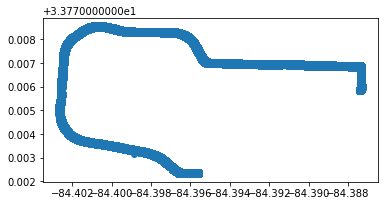

In [10]:
lidarGDF.plot()

In [11]:
lidarGDF.head()

,Id,X,Y,Z,Angle,Distance,Retro,UTC,geometry
0,0,-84.387425,33.775820,270.5789,0.78540,8.39,0.221,55758.31463,POINT (-84.38742 33.77582)
1,1,-84.387424,33.775821,270.5814,0.77667,8.32,0.221,55758.31471,POINT (-84.38742 33.77582)
2,2,-84.387424,33.775822,270.5843,0.76794,8.25,0.221,55758.31478,POINT (-84.38742 33.77582)
3,3,-84.387424,33.775823,270.5786,0.75922,8.21,0.221,55758.31485,POINT (-84.38742 33.77582)
4,4,-84.387424,33.775824,270.5855,0.75049,8.13,0.221,55758.31493,POINT (-84.38742 33.77582)
